# Tutorial on Riemannian Wasserstein Flow Matching

Here we present a tutorial on how to run RWFM for point-cloud generation on spherical manifolds.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
import jax
import numpy as np
import matplotlib.pyplot as plt

import skimage
from tqdm import tqdm

In [3]:
from riemannianwassersteinflowmatching import RiemannianWassersteinFlowMatching


# Load MNIST Images

In [4]:
# import tensorflow.keras.datasets
# mnist = tensorflow.keras.datasets.mnist

# (image_train, label_train), (image_test, label_test) = mnist.load_data()


from emnist import extract_training_samples, extract_test_samples

image_train, label_train = extract_training_samples('mnist')

# Load testing data
image_test, label_test = extract_test_samples('mnist')

image_train, image_test = image_train/255.0, image_test/255.0


subset to images with the label 3:

In [5]:
image_train = image_train[label_train == 3]
image_test = image_test[label_test == 3]

and convert to point-clouds

In [6]:
pc_train = [2 * (np.stack(np.where(im > skimage.filters.threshold_otsu(im)), axis = -1))/28 - 1 for im in tqdm(image_train)]
pc_test = [2 * (np.stack(np.where(im > skimage.filters.threshold_otsu(im)), axis = -1))/28 - 1  for im in tqdm(image_test)]

pc_train = [np.clip(pc + np.random.normal(0, 0.02, pc.shape), -0.98 ,0.98) for pc in pc_train]
pc_test = [np.clip(pc + np.random.normal(0, 0.02, pc.shape), -0.98,0.98) for pc in pc_test]

pc_train = [np.stack([pc[:, 1], -pc[:, 0]], axis = 0).T for pc in pc_train]
pc_test = [np.stack([pc[:, 1], -pc[:, 0]], axis = 0).T for pc in pc_test]

100%|████████████████████████████████████| 1000/1000 [00:00<00:00, 10567.26it/s]


## Map to sphere

In [7]:
def square_to_sphere(points):
    """
    Convert points from a square [-1,1]^2 to spherical coordinates (theta, phi) on a unit sphere.
    
    Args:
    points (np.array): Array of shape (N, 2) containing N points in [-1,1]^2
    
    Returns:
    np.array: Array of shape (N, 2) containing N points as (theta, phi)
              where theta in [0, 2π] and phi in [0, π]
    """
    points = np.array(points)
    
    if np.any(points < -1) or np.any(points > 1):
        points = np.clip(points, -1, 1)
        #raise ValueError("All points must be within the [-1,1]^2 square")
    
    x, y = points[:, 0], points[:, 1]
    
    # Convert to intermediate spherical coordinates
    theta = np.pi*x
    phi = np.pi * (y-1)/2#(y+1)/2
    
    x = np.sin(phi) * np.cos(theta)
    y = np.sin(phi) * np.sin(theta)
    z = np.cos(phi)

    return np.column_stack((x, y, z))

In [8]:
pc_train = [square_to_sphere(pc) for pc in pc_train]
pc_test = [square_to_sphere(pc) for pc in pc_test]

## Visualize

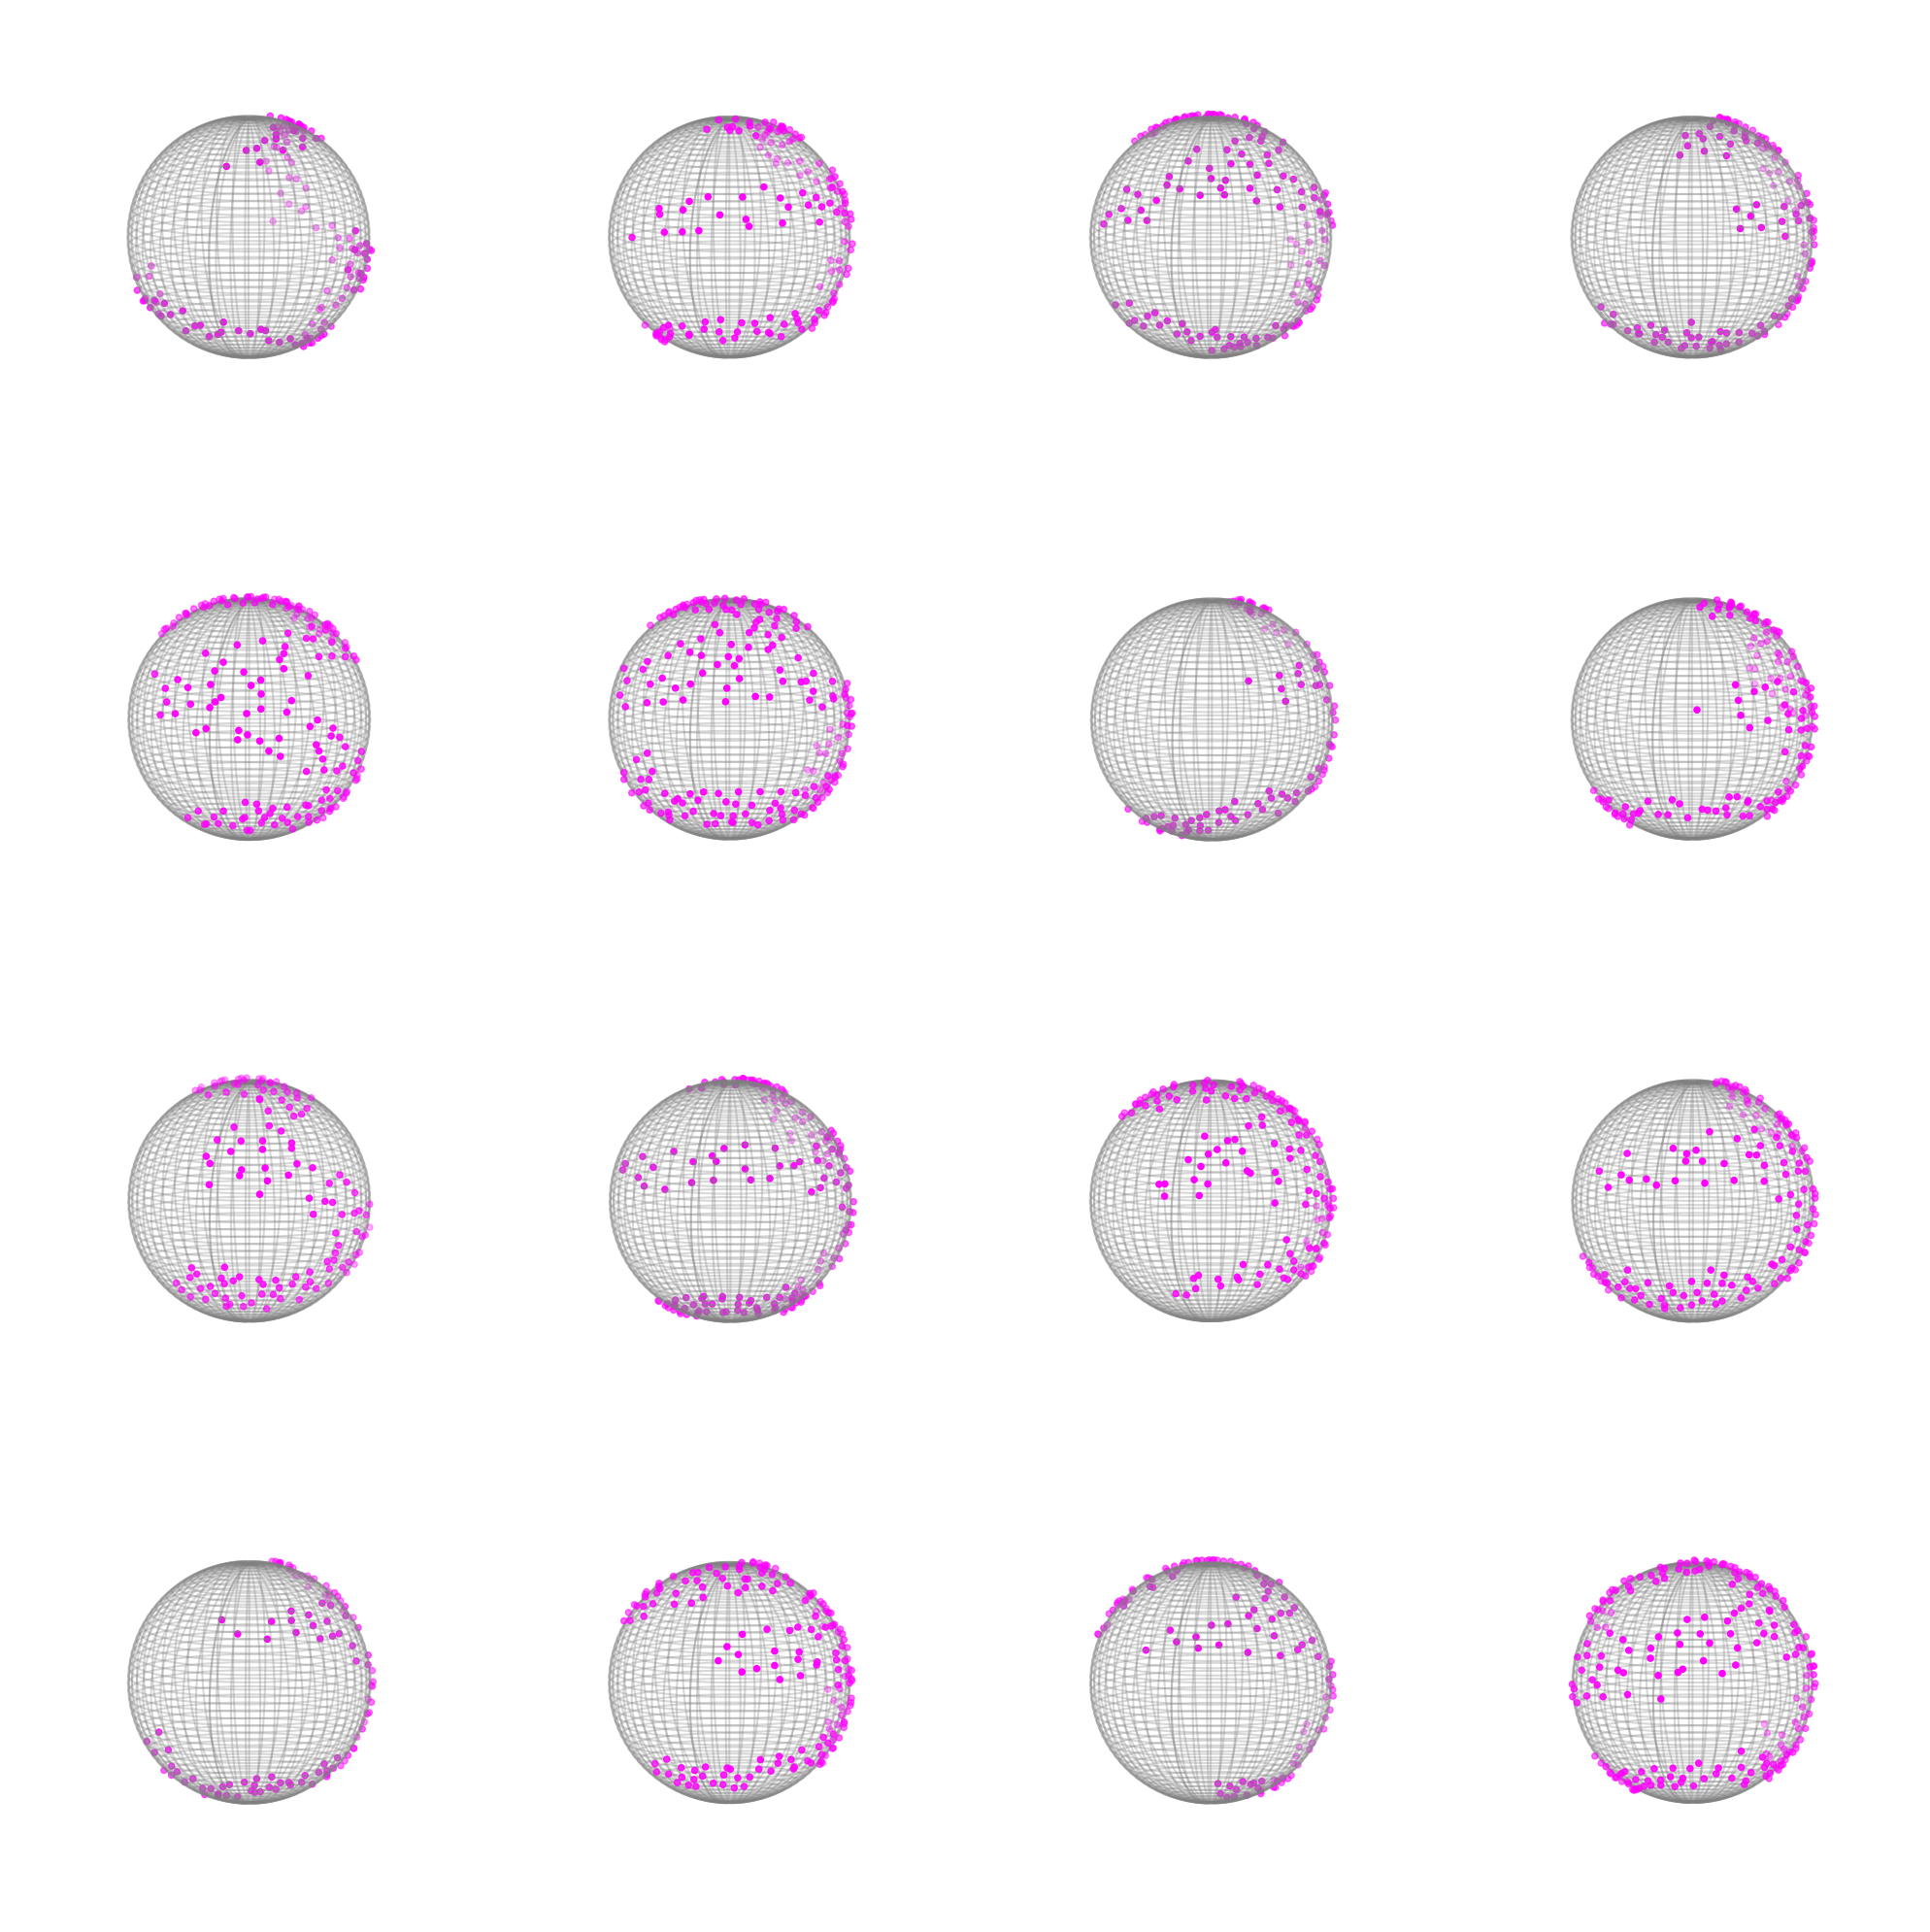

In [9]:
fig = plt.figure(figsize=(20, 20)) 
for ind in range(16):
    ax = fig.add_subplot(4, 4, 1+ind, projection='3d')

    u = np.linspace(0, 2 * np.pi, 100) 
    v = np.linspace(0, np.pi, 100) 
    x = np.outer(np.cos(u), np.sin(v)) * 0.98
    y = np.outer(np.sin(u), np.sin(v)) * 0.98
    z = np.outer(np.ones(np.size(u)), np.cos(v))* 0.98

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    ax.plot_wireframe(x, y, z, color='grey', alpha=0.3, zorder = 1)

    i = np.random.choice(np.arange(len(pc_train)))
    points = pc_train[i]


    ax.scatter(points[:, 0], 
               points[:, 1], 
               points[:, 2],  c = 'magenta', depthshade=True, zorder = 2)




    ax.view_init(azim=160, elev=-10)

    ax.axis('off')

    
    plt.gca().set_aspect('equal')

plt.tight_layout()
plt.show()


# Run Riemannian Wasserstein Flow Matching

In [10]:
class rwfm_config:
    geom: str = 'sphere'
    monge_map: str = 'entropic'
    wasserstein_eps: float = 0.002
    wasserstein_lse: bool = True
    num_sinkhorn_iters: int = -1
    mini_batch_ot_mode: bool = True
    mini_batch_ot_solver: str = 'chamfer'
    minibatch_ot_eps: float = 0.01
    mini_batch_ot_num_iter = -1
    minibatch_ot_lse: bool = True
    noise_type: str = 'ambient_gaussian'
    noise_geom: str = 'sphere'
    embedding_dim: int = 512
    num_layers: int = 6
    num_heads: int = 4
    dropout_rate: float = 0.1
    mlp_hidden_dim: int = 512
    cfg: bool = False
    p_cfg_null: float = 0.0
    w_cfg: float = 1.0
    normalized_condition: bool = False


In [11]:
FlowMatchingModel = RiemannianWassersteinFlowMatching(point_clouds = pc_train, 
                                                      config = rwfm_config)

Initializing WassersteinFlowMatching
Using sphere geometry
Projecting point clouds to geometry (with cpu)...


100%|████████████████████████████████████| 6000/6000 [00:00<00:00, 56748.67it/s]


Using sphere geometry for noise


Estimating Gaussian Params: 100%|███████████████| 12/12 [00:01<00:00,  6.84it/s]


Using ambient_gaussian noise for sphere geometry.
Noise parameters:
  mean: [-0.39352652 -0.14089315  0.04117293]
  cov_chol_mean: [[ 0.32626998  0.          0.        ]
 [-0.0087153   0.50306624  0.        ]
 [-0.02215037 -0.06348585  0.6192895 ]]
  cov_chol_std: [[0.06068567 0.         0.        ]
 [0.0776302  0.05292469 0.        ]
 [0.09496602 0.16498633 0.05135731]]
  noise_df_scale: 1.0
Finding optimal number of Sinkhorn iterations...
INFO: Found sufficient convergence (95%) at 490 iterations.
Auto-selected 490 Sinkhorn iterations.
Using entropic map with 490 iterations and 0.002 epsilon
Chamfer Mini-Batch
Finding optimal number of Sinkhorn iterations for Mini-Batch OT...
Auto-selected 50 Sinkhorn iterations for Mini-Batch OT.


## Train Model

Train Model & Plot loss curve

In [12]:

FlowMatchingModel.train(batch_size = 32, 
                        training_steps = 500000, 
                        decay_steps = 5000)

Creating new train state
Train state created


: 1.026e-02: 100%|████████████████████| 500000/500000 [3:36:24<00:00, 38.51it/s]


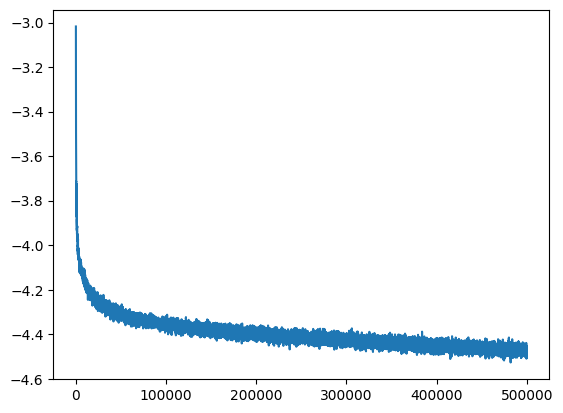

In [13]:
loss_smooth = np.convolve(np.log(FlowMatchingModel.losses), np.ones(100)/100, mode='valid')
plt.plot(loss_smooth)

# Generate Samples

Set Initial Key

In [14]:
key = jax.random.PRNGKey(0)

Run Flow for 1000 timesteps

In [15]:

subkey,key = jax.random.split(key)
generated_samples, sample_weights = FlowMatchingModel.generate_samples(num_samples = 16,
                                                            timesteps = 1000,
                                                            key = subkey)

Plot resulting point clouds

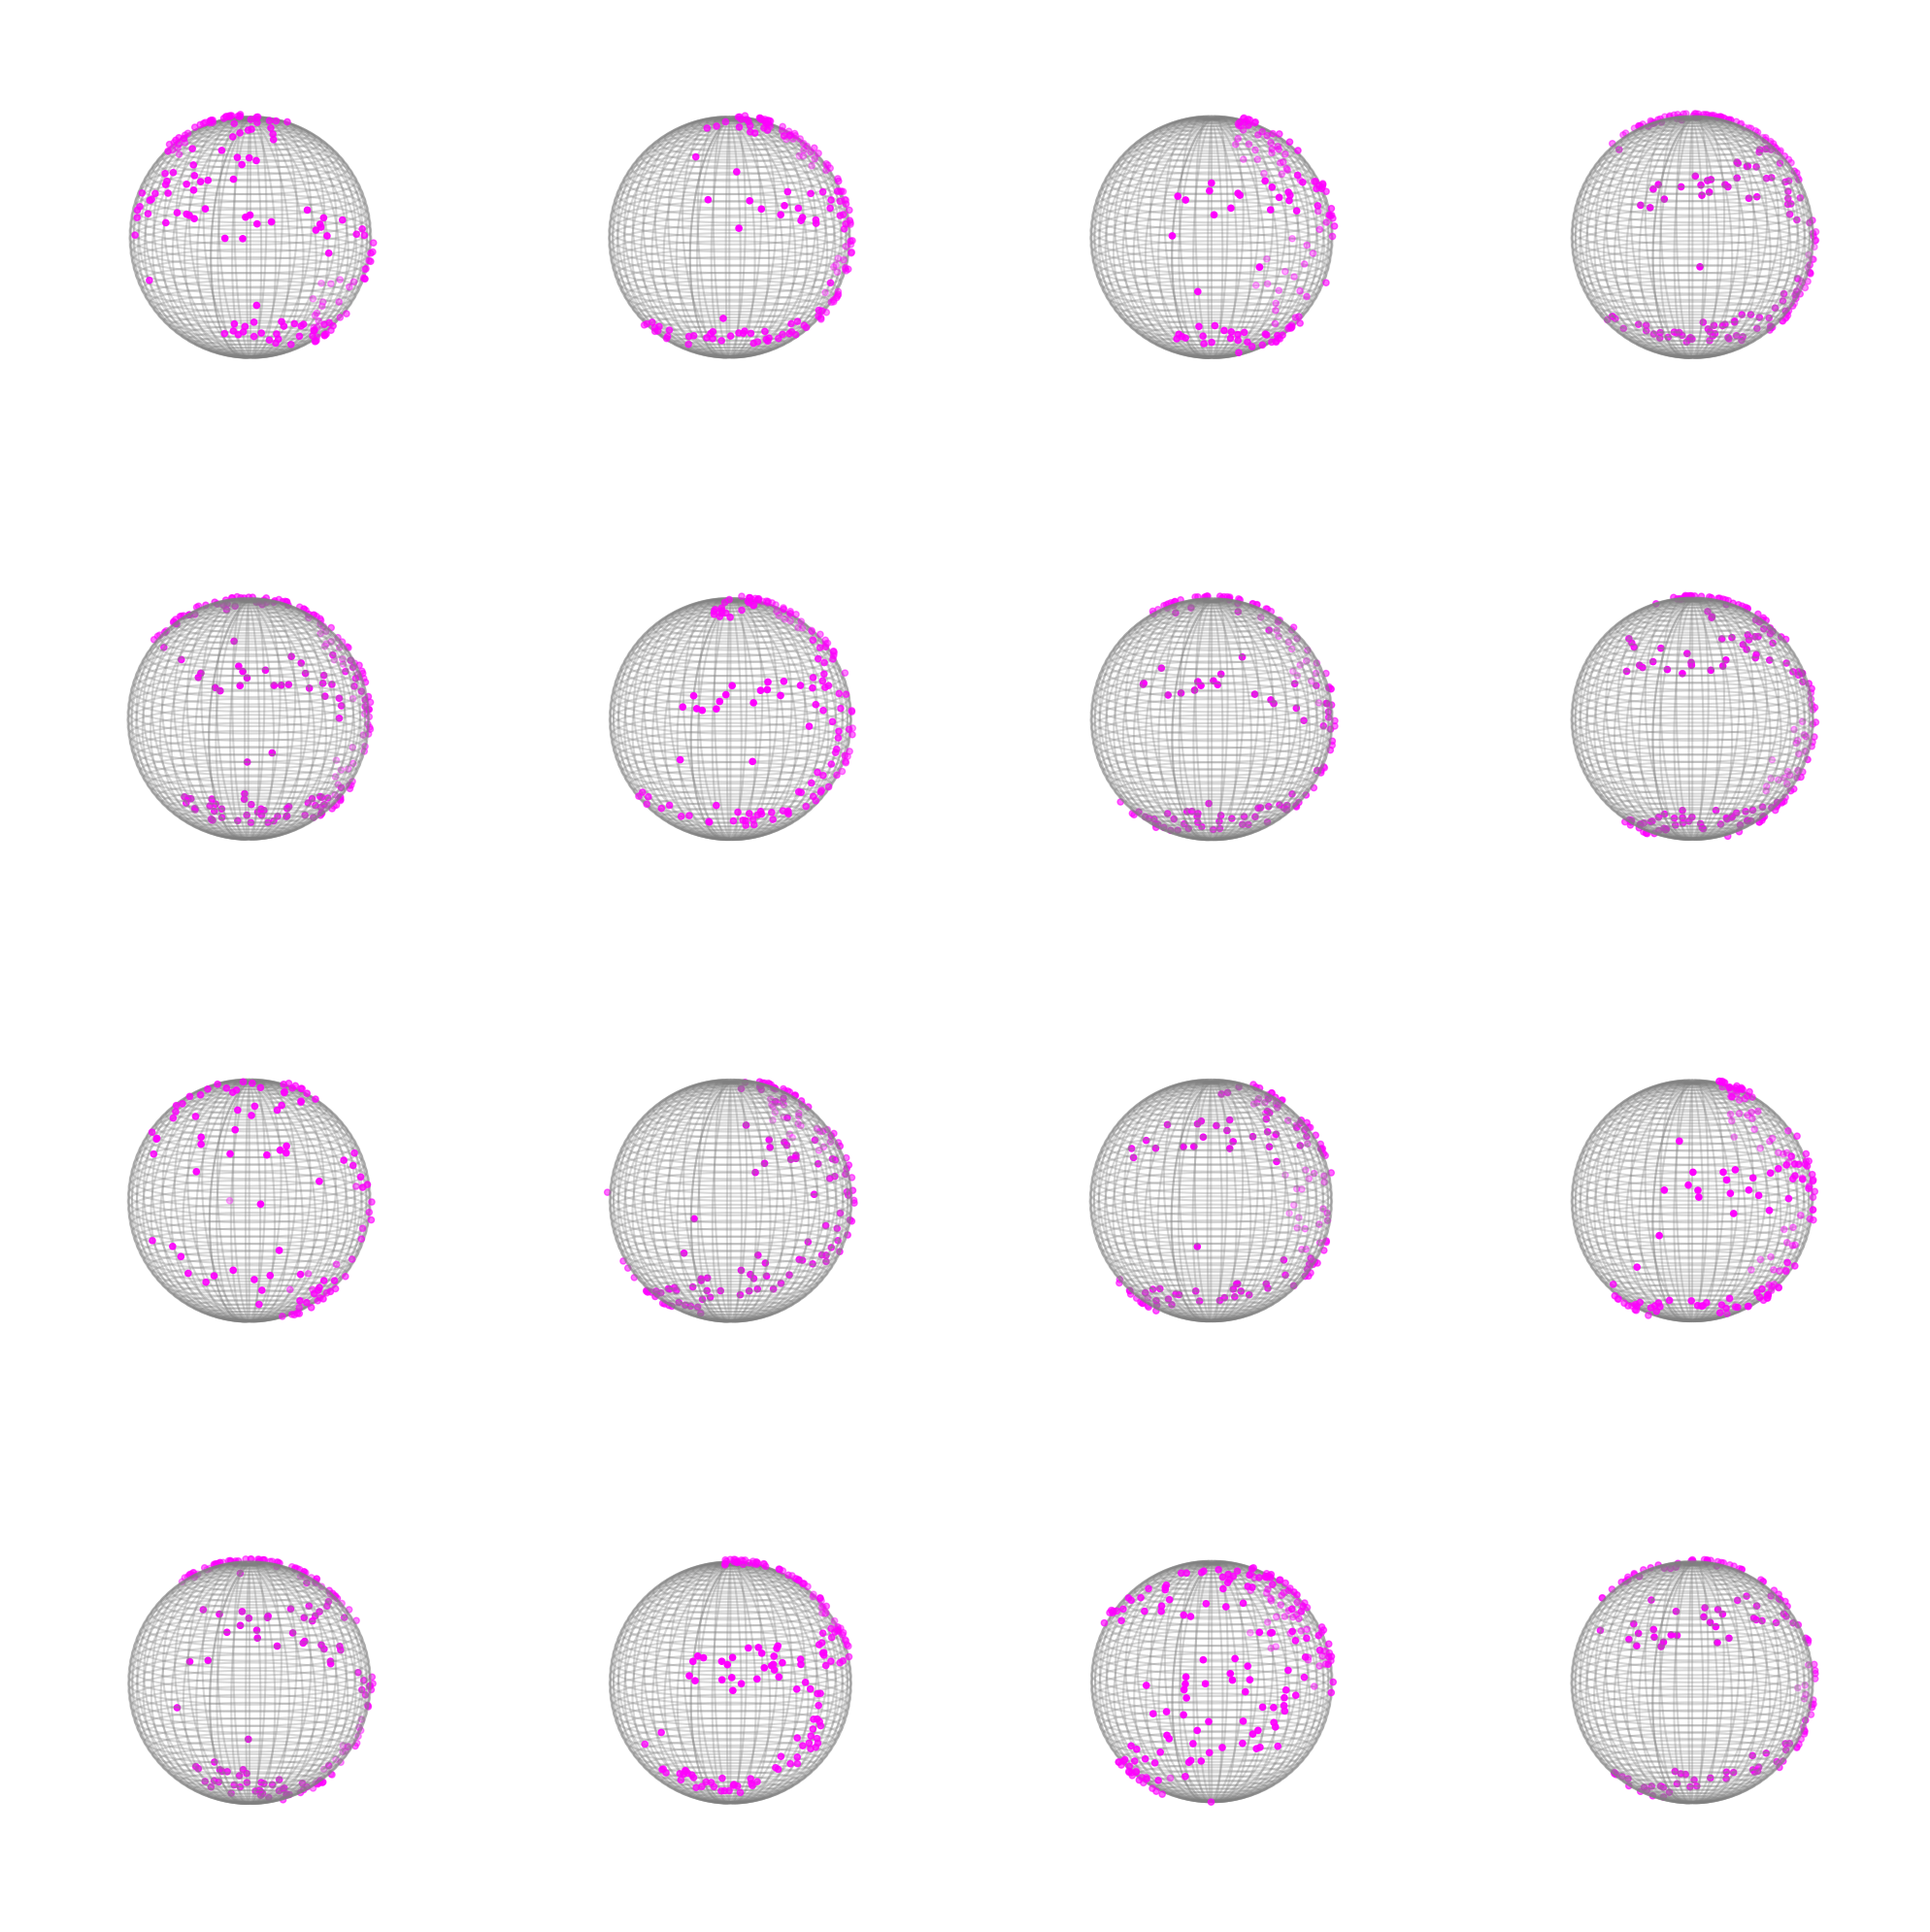

In [16]:
fig = plt.figure(figsize=(20, 20)) 
for ind in range(16):
    ax = fig.add_subplot(4, 4, 1+ind, projection='3d')

    u = np.linspace(0, 2 * np.pi, 100) 
    v = np.linspace(0, np.pi, 100) 
    x = np.outer(np.cos(u), np.sin(v)) * 0.98
    y = np.outer(np.sin(u), np.sin(v)) * 0.98
    z = np.outer(np.ones(np.size(u)), np.cos(v))* 0.98

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    ax.plot_wireframe(x, y, z, color='grey', alpha=0.3, zorder = 1)

    points = generated_samples[-1][ind][sample_weights[ind]>0]


    ax.scatter(points[:, 0], 
               points[:, 1], 
               points[:, 2],  c = 'magenta', depthshade=True, zorder = 2)




    ax.view_init(azim=160, elev=-10)

    ax.axis('off')

    
    plt.gca().set_aspect('equal')

plt.tight_layout()
plt.show()
